# CS 171 Final Project — TrashNet Data Preprocessing & Model Construction
### Waste Classification with Classical ML and CNNs
**Author:** Soham Bhowmick  and Lwin Moe
**Date:** December 4, 2025

---

## Project Overview

This notebook presents the complete data preprocessing and model construction pipeline for the **TrashNet dataset**. The goal is to classify waste images into 6 categories: cardboard, glass, metal, paper, plastic, and trash.

### Research Question
*How effectively can machine learning models classify waste images for automated sorting, and how do classical ML approaches compare to deep learning (CNNs)?*

### Dataset
- **TrashNet**: Studio-quality waste images (2,527 total images)
- **Classes**: cardboard (403), glass (501), metal (410), paper (594), plastic (482), trash (137)
- **Image Size**: Resized to 200×200 pixels

### Models Implemented
1. **Classical ML** (using scikit-learn):
   - K-Nearest Neighbors (KNN)
   - Logistic Regression
   - Decision Tree
   - Random Forest
   - Ensemble Majority Voting

2. **Deep Learning** (using PyTorch):
   - Convolutional Neural Network (CNN) with Dropout & Data Augmentation

---
# Part 1: Data Preprocessing
---

## 1.1 Import Required Libraries

In [1]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from collections import Counter
from tqdm import tqdm

# Scikit-learn for classical ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_curve, roc_auc_score)

# PyTorch for CNN
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

# random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# setting up device for pytorch
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 1.2 Dataset Configuration

The TrashNet dataset is organized in the following structure:
```
data/Trashnet-resized/
├── cardboard/   (403 images)
├── glass/       (501 images)
├── metal/       (410 images)
├── paper/       (594 images)
├── plastic/     (482 images)
└── trash/       (137 images)
```

Each image has been pre-resized to 200×200 pixels.

In [4]:
# defining paths and class names
DATA_DIR = "data/Trashnet-resized"
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
IMG_SIZE = 200  # Images are 200x200

# verifying dataset exists and counting images per class
print("TrashNet Dataset Summary:")
print("-" * 40)
total_images = 0
class_counts = {}

for class_name in CLASSES:
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path) 
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = count
        total_images += count
        print(f"  {class_name:12s}: {count:4d} images")
    else:
        print(f"  {class_name:12s}: NOT FOUND")
        
print("-" * 40)
print(f"  {'TOTAL':12s}: {total_images:4d} images")

TrashNet Dataset Summary:
----------------------------------------
  cardboard   :  403 images
  glass       :  501 images
  metal       :  410 images
  paper       :  594 images
  plastic     :  482 images
  trash       :  137 images
----------------------------------------
  TOTAL       : 2527 images


## 1.3 Visualize Class Distribution

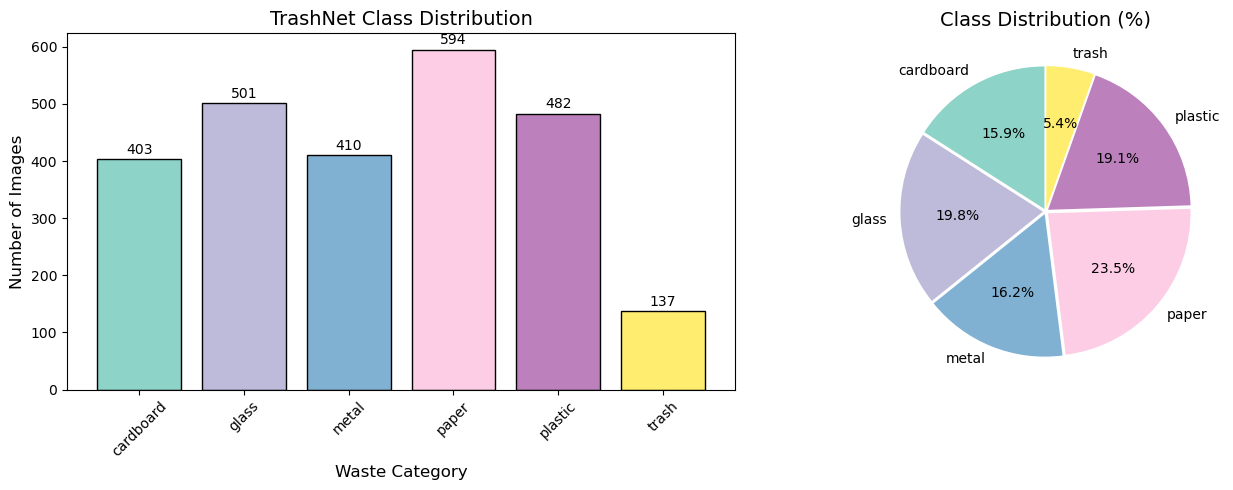


Note: Class imbalance detected - 'trash' has only 137 images


In [5]:
# visualizing class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# bar chart
colors = plt.cm.Set3(np.linspace(0, 1, len(CLASSES)))
bars = axes[0].bar(class_counts.keys(), class_counts.values(), color=colors, edgecolor='black')
axes[0].set_xlabel('Waste Category', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].set_title('TrashNet Class Distribution', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# add count labels on bars
for bar, count in zip(bars, class_counts.values()):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 str(count), ha='center', va='bottom', fontsize=10)

# pie chart
axes[1].pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%',
            colors=colors, startangle=90, explode=[0.02]*len(CLASSES))
axes[1].set_title('Class Distribution (%)', fontsize=14)

plt.tight_layout()
plt.show()

print(f"\nNote: Class imbalance detected - 'trash' has only {class_counts['trash']} images")

## 1.4 Preview Sample Images

Let's visualize a sample image from each waste category to understand the data.

/var/folders/m2/s530m3_j25s5l47hq37j0by40000gn/T/ipykernel_88828/675618314.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


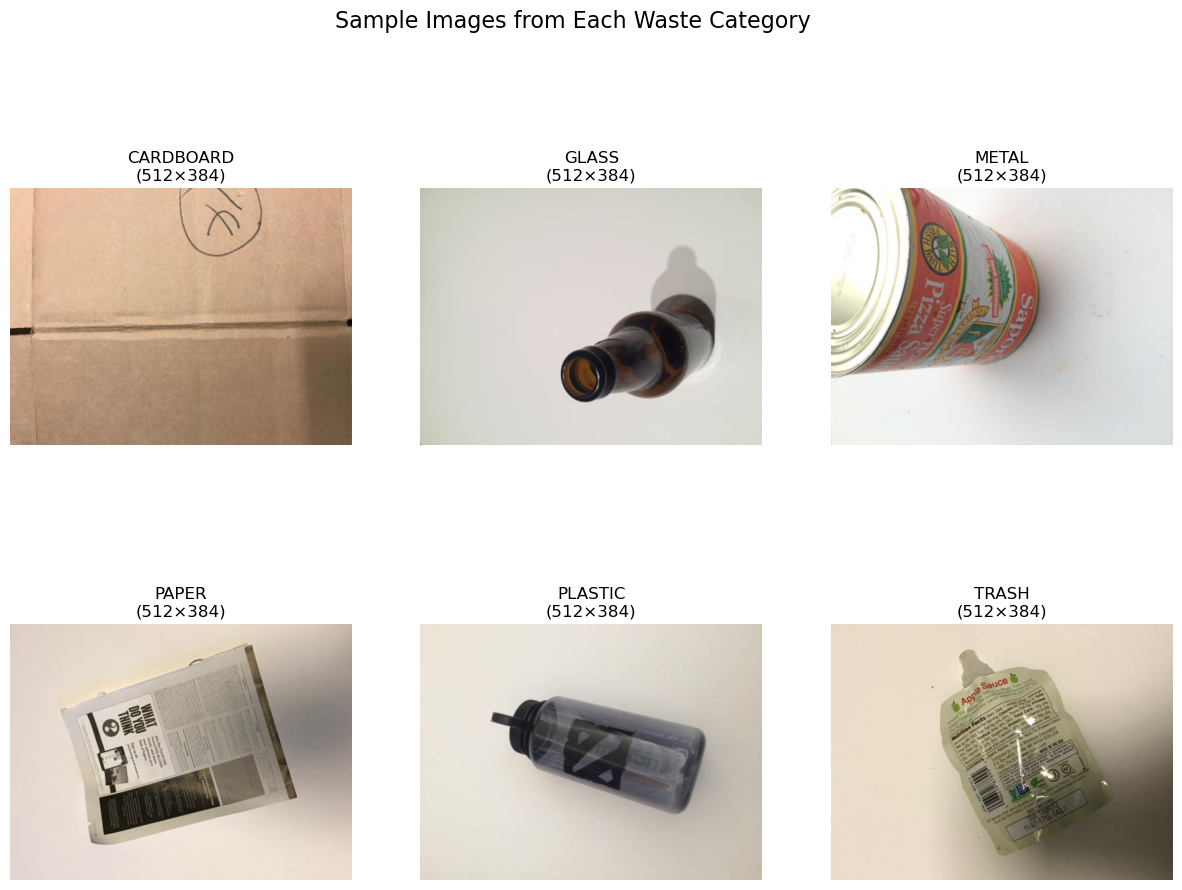

In [6]:
# displaying sample images from each class
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3, hspace=0.3)

for idx, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATA_DIR, class_name)
    # filtering for valid image extensions to avoid hidden files
    image_files = sorted([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    if not image_files:
        print(f"No images found in {class_path}")
        continue

    # load first image from each class
    img_path = os.path.join(class_path, image_files[0])
    
    try:
        img = Image.open(img_path).convert('RGB')
        
        ax = fig.add_subplot(gs[idx // 3, idx % 3])
        ax.imshow(img)
        ax.set_title(f'{class_name.upper()}\n({img.size[0]}×{img.size[1]})', fontsize=12)
        ax.axis('off')
    except Exception as e:
        print(f"Error loading {img_path}: {e}")
        # Debug info
        if os.path.exists(img_path):
            print(f"  File exists. Size: {os.path.getsize(img_path)} bytes")
            with open(img_path, 'rb') as f:
                header = f.read(10)
                print(f"  Header bytes: {header}")
        else:
            print(f"  File does not exist at absolute path: {os.path.abspath(img_path)}")

plt.suptitle('Sample Images from Each Waste Category', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 1.5 Build Dataset Table and Create Stratified Splits

We create train/validation/test splits with a 70/15/15 ratio using stratified sampling to maintain class proportions.

In [7]:
# building dataset DataFrame
data = []
for class_idx, class_name in enumerate(CLASSES):
    class_path = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            data.append({
                'filepath': os.path.join(class_path, img_name),
                'label': class_name,
                'label_idx': class_idx
            })

df = pd.DataFrame(data)
print(f"Total samples: {len(df)}")
print(f"\nClass distribution:\n{df['label'].value_counts()}")

Total samples: 2527

Class distribution:
label
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64


In [8]:
# creating stratified train/val/test splits (70/15/15)
# first split: 70% train, 30% temp
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df['label'], random_state=42
)

# second split: 50% of temp = 15% val, 15% test
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42
)

print(f"Dataset splits:")
print(f"  Train: {len(train_df):4d} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df):4d} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df):4d} samples ({len(test_df)/len(df)*100:.1f}%)")

# saving splits to CSV
os.makedirs("splits/trashnet", exist_ok=True)
train_df.to_csv("splits/trashnet/train.csv", index=False)
val_df.to_csv("splits/trashnet/val.csv", index=False)
test_df.to_csv("splits/trashnet/test.csv", index=False)
print("\nSplit files saved to splits/trashnet/")

Dataset splits:
  Train: 1768 samples (70.0%)
  Val:    379 samples (15.0%)
  Test:   380 samples (15.0%)

Split files saved to splits/trashnet/


## 1.6 Compute Dataset Statistics (Mean & Std)

These normalization values are required for:
- Normalizing images before training CNNs
- Ensuring stable model convergence
- Matching standard computer vision pipelines

In [8]:
# computing dataset mean and std using the full training set
# ensure tqdm is available
try:
    from tqdm import tqdm
except ImportError:
    # fallback if tqdm is not available
    def tqdm(iterable, desc=""):
        return iterable

print("Computing dataset statistics on the full training set...")

# using all training images
sample_paths = train_df['filepath'].values

channel_sum = np.zeros(3)
channel_sq_sum = np.zeros(3)
pixel_count = 0

for filepath in tqdm(sample_paths, desc="Processing images"):
    try:
        # resizing to 200x200 (target size) to speed up processing and match model input
        img = Image.open(filepath).convert("RGB").resize((200, 200))
        img = np.array(img) / 255.0
        
        channel_sum += img.sum(axis=(0, 1))
        channel_sq_sum += (img ** 2).sum(axis=(0, 1))
        pixel_count += img.shape[0] * img.shape[1]
    except Exception as e:
        print(f"Warning: Could not process image {filepath}: {e}")
        continue

dataset_mean = channel_sum / pixel_count
dataset_std = np.sqrt(channel_sq_sum / pixel_count - dataset_mean ** 2)

print(f"\nDataset statistics (computed on full training set):")
print(f"  Mean: [{dataset_mean[0]:.4f}, {dataset_mean[1]:.4f}, {dataset_mean[2]:.4f}]")
print(f"  Std:  [{dataset_std[0]:.4f}, {dataset_std[1]:.4f}, {dataset_std[2]:.4f}]")

Computing dataset statistics on the full training set...


Processing images: 100%|████████████████████| 1768/1768 [35:28<00:00,  1.20s/it]


Dataset statistics (computed on full training set):
  Mean: [0.6720, 0.6389, 0.6043]
  Std:  [0.2083, 0.2097, 0.2316]


---
# Part 2: Model Construction
---

## 2.1 Prepare Features for Classical ML

For classical ML models (KNN, Logistic Regression, Decision Trees), we need to flatten images into feature vectors.

In [9]:
def load_and_flatten_images(df, img_size=200):
    X = []
    y = []
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Loading images"):
        try:
            img = Image.open(row['filepath']).convert('RGB')
            img = img.resize((img_size, img_size))
            img_array = np.array(img) / 255.0  # Normalize to [0, 1]
            X.append(img_array.flatten())
            y.append(row['label_idx'])
        except Exception as e:
            print(f"Warning: Could not load image {row['filepath']}: {e}")
            continue
    
    return np.array(X), np.array(y)

# loading data for classical ML (using smaller size for efficiency)
CLASSICAL_IMG_SIZE = 64  # Reduce to 64x64 for classical ML (faster training)

print("Loading training data...")
X_train, y_train = load_and_flatten_images(train_df, CLASSICAL_IMG_SIZE)

print("Loading validation data...")
X_val, y_val = load_and_flatten_images(val_df, CLASSICAL_IMG_SIZE)

print("Loading test data...")
X_test, y_test = load_and_flatten_images(test_df, CLASSICAL_IMG_SIZE)

print(f"\nFeature shapes:")
print(f"  X_train: {X_train.shape} ({X_train.shape[1]} features per image)")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

Loading training data...


Loading images: 100%|██████████████████████| 1768/1768 [00:05<00:00, 346.11it/s]


Loading validation data...


Loading images: 100%|█████████████████████████| 379/379 [07:06<00:00,  1.12s/it]


Loading test data...


Loading images: 100%|█████████████████████████| 380/380 [07:28<00:00,  1.18s/it]


Feature shapes:
  X_train: (1768, 12288) (12288 features per image)
  X_val:   (379, 12288)
  X_test:  (380, 12288)


In [10]:
# standardizing features for classical ML
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features standardized (zero mean, unit variance)")

Features standardized (zero mean, unit variance)


## 2.2 Classical ML Models

We implement and compare several classical machine learning classifiers covered in lectures.

In [11]:
# defining classical ML models
classical_models = {
    'KNN (k=5)': KNeighborsClassifier(n_neighbors=5),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
}

# training and evaluate each model
classical_results = {}

print("Training Classical ML Models")
print("=" * 60)

for name, model in classical_models.items():
    print(f"\nTraining {name}...")
    
    # training
    model.fit(X_train_scaled, y_train)
    
    # evaluating on validation set
    val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    
    # evaluating on test set
    test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    
    classical_results[name] = {
        'model': model,
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'test_predictions': test_pred
    }
    
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy:       {test_acc:.4f}")

Training Classical ML Models

Training KNN (k=5)...
  Validation Accuracy: 0.4802
  Test Accuracy:       0.5263

Training Logistic Regression...
  Validation Accuracy: 0.4301
  Test Accuracy:       0.4289

Training Decision Tree...
  Validation Accuracy: 0.5172
  Test Accuracy:       0.4763

Training Random Forest...
  Validation Accuracy: 0.6834
  Test Accuracy:       0.7158


## 2.3 Ensemble Majority Voting Classifier



In [12]:
# creating ensemble with majority voting
voters = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=20, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42))
]

voting_clf = VotingClassifier(estimators=voters, voting='hard')

print("Training Ensemble (Majority Voting)...")
voting_clf.fit(X_train_scaled, y_train)

# evaluating
val_pred_voting = voting_clf.predict(X_val_scaled)
test_pred_voting = voting_clf.predict(X_test_scaled)

val_acc_voting = accuracy_score(y_val, val_pred_voting)
test_acc_voting = accuracy_score(y_test, test_pred_voting)

classical_results['Ensemble (Voting)'] = {
    'model': voting_clf,
    'val_accuracy': val_acc_voting,
    'test_accuracy': test_acc_voting,
    'test_predictions': test_pred_voting
}

print(f"  Validation Accuracy: {val_acc_voting:.4f}")
print(f"  Test Accuracy:       {test_acc_voting:.4f}")

Training Ensemble (Majority Voting)...
  Validation Accuracy: 0.6385
  Test Accuracy:       0.6579


## 2.4 Classical ML Results Summary


Classical ML Results Summary
Model                          Val Acc     Test Acc
------------------------------------------------------------
KNN (k=5)                       0.4802       0.5263
Logistic Regression             0.4301       0.4289
Decision Tree                   0.5172       0.4763
Random Forest                   0.6834       0.7158
Ensemble (Voting)               0.6385       0.6579


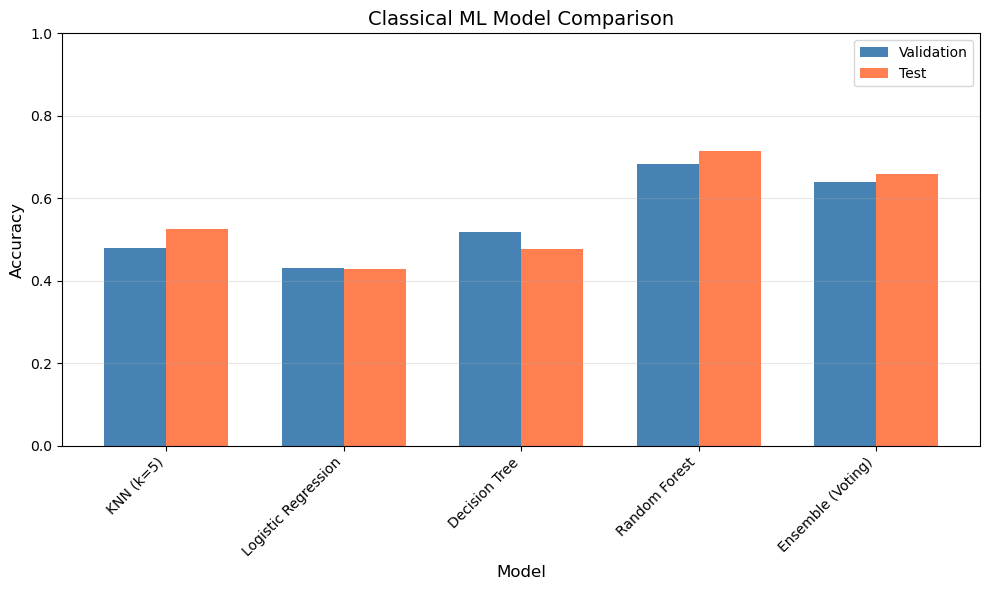

In [13]:
# summary of classical ML results
print("\nClassical ML Results Summary")
print("=" * 60)
print(f"{'Model':<25} {'Val Acc':>12} {'Test Acc':>12}")
print("-" * 60)

for name, result in classical_results.items():
    print(f"{name:<25} {result['val_accuracy']:>12.4f} {result['test_accuracy']:>12.4f}")

# bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))
models_names = list(classical_results.keys())
val_accs = [r['val_accuracy'] for r in classical_results.values()]
test_accs = [r['test_accuracy'] for r in classical_results.values()]

x = np.arange(len(models_names))
width = 0.35

bars1 = ax.bar(x - width/2, val_accs, width, label='Validation', color='steelblue')
bars2 = ax.bar(x + width/2, test_accs, width, label='Test', color='coral')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Classical ML Model Comparison', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models_names, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 2.5 Convolutional Neural Network (CNN)

Now we implement a CNN following the architecture patterns from Lectures 8-1 and 8-2, with improvements including:
- Multiple convolutional layers with ReLU activation
- Max pooling for spatial reduction  
- Dropout for regularization (to prevent overfitting)
- Data augmentation for training

In [14]:
# defining CNN Architecture
class WasteClassificationCNN(nn.Module):
    """
    CNN for waste image classification.
    Architecture: Conv -> ReLU -> Pool -> Conv -> ReLU -> Pool -> Conv -> ReLU -> Pool -> FC -> Dropout -> FC
    """
    def __init__(self, num_classes=6):
        super(WasteClassificationCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Conv Block 1: 3 -> 32 channels
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 200 -> 100
            
            # Conv Block 2: 32 -> 64 channels
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 100 -> 50
            
            # Conv Block 3: 64 -> 128 channels
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 50 -> 25
        )
        
        # fully connected layers
        # after 3 pooling layers: 200 -> 100 -> 50 -> 25
        # feature map size: 128 * 25 * 25 = 80000
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 25 * 25, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# creating model instance
model = WasteClassificationCNN(num_classes=6).to(device)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

WasteClassificationCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=80000, out_features=512, bias=True)
    (2): ReLU()

### 2.5.1 Data Loaders with Augmentation

Following Lecture 8-2, we use data augmentation to prevent overfitting.

In [15]:
# defining transforms
# training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
])

# validation/test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
])

# custom dataset class
class TrashNetDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['filepath']).convert('RGB')
        label = row['label_idx']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# creating datasets
train_dataset = TrashNetDataset(train_df, transform=train_transform)
val_dataset = TrashNetDataset(val_df, transform=test_transform)
test_dataset = TrashNetDataset(test_df, transform=test_transform)

# creating data loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

DataLoaders created:
  Train batches: 56
  Val batches:   12
  Test batches:  12


### 2.5.2 Training Loop

Define the training loop with loss tracking and early stopping.

In [16]:
def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        
        # validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)
        
        # step the scheduler
        scheduler.step(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        
        # saving best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), 'best_cnn_model.pth')
            
    print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs

### 2.5.3 Train the CNN

We train the model for 30 epochs. The best model (based on validation accuracy) is saved automatically.

In [17]:
# training the model
NUM_EPOCHS = 30
LEARNING_RATE = 0.001

print(f"Starting training for {NUM_EPOCHS} epochs...")
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, 
    num_epochs=NUM_EPOCHS, 
    learning_rate=LEARNING_RATE
)

/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Starting training for 30 epochs...


Epoch 1/30 [Train]: 100%|███████████████████████| 56/56 [00:27<00:00,  2.00it/s]


Epoch 1/30 - Train Loss: 3.7093, Train Acc: 0.2472 | Val Loss: 1.5500, Val Acc: 0.3720


Epoch 2/30 [Train]: 100%|███████████████████████| 56/56 [00:26<00:00,  2.13it/s]


Epoch 2/30 - Train Loss: 1.7042, Train Acc: 0.3196 | Val Loss: 1.4262, Val Acc: 0.4090


Epoch 3/30 [Train]: 100%|███████████████████████| 56/56 [00:28<00:00,  2.00it/s]


Epoch 3/30 - Train Loss: 1.6116, Train Acc: 0.3614 | Val Loss: 1.3995, Val Acc: 0.3852


Epoch 4/30 [Train]: 100%|███████████████████████| 56/56 [00:26<00:00,  2.10it/s]


Epoch 4/30 - Train Loss: 1.5588, Train Acc: 0.3733 | Val Loss: 1.3717, Val Acc: 0.4195


Epoch 5/30 [Train]: 100%|███████████████████████| 56/56 [00:28<00:00,  1.95it/s]


Epoch 5/30 - Train Loss: 1.5550, Train Acc: 0.3869 | Val Loss: 1.3331, Val Acc: 0.4512


Epoch 6/30 [Train]: 100%|███████████████████████| 56/56 [00:26<00:00,  2.09it/s]


Epoch 6/30 - Train Loss: 1.4703, Train Acc: 0.4095 | Val Loss: 1.3150, Val Acc: 0.4406


Epoch 7/30 [Train]: 100%|███████████████████████| 56/56 [00:26<00:00,  2.12it/s]


Epoch 7/30 - Train Loss: 1.4637, Train Acc: 0.4259 | Val Loss: 1.2899, Val Acc: 0.4670


Epoch 8/30 [Train]: 100%|███████████████████████| 56/56 [00:27<00:00,  2.03it/s]


Epoch 8/30 - Train Loss: 1.4592, Train Acc: 0.4180 | Val Loss: 1.2302, Val Acc: 0.5013


Epoch 9/30 [Train]: 100%|███████████████████████| 56/56 [00:26<00:00,  2.09it/s]


Epoch 9/30 - Train Loss: 1.4471, Train Acc: 0.4231 | Val Loss: 1.2128, Val Acc: 0.5251


Epoch 10/30 [Train]: 100%|██████████████████████| 56/56 [00:27<00:00,  2.05it/s]


Epoch 10/30 - Train Loss: 1.4113, Train Acc: 0.4327 | Val Loss: 1.2088, Val Acc: 0.5594


Epoch 11/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.15it/s]


Epoch 11/30 - Train Loss: 1.3655, Train Acc: 0.4548 | Val Loss: 1.1594, Val Acc: 0.5277


Epoch 12/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.12it/s]


Epoch 12/30 - Train Loss: 1.3543, Train Acc: 0.4581 | Val Loss: 1.1776, Val Acc: 0.5488


Epoch 13/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.12it/s]


Epoch 13/30 - Train Loss: 1.3603, Train Acc: 0.4553 | Val Loss: 1.1500, Val Acc: 0.5594


Epoch 14/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.12it/s]


Epoch 14/30 - Train Loss: 1.3627, Train Acc: 0.4593 | Val Loss: 1.1832, Val Acc: 0.5383


Epoch 15/30 [Train]: 100%|██████████████████████| 56/56 [00:29<00:00,  1.91it/s]


Epoch 15/30 - Train Loss: 1.3322, Train Acc: 0.4740 | Val Loss: 1.1996, Val Acc: 0.5594


Epoch 16/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.10it/s]


Epoch 16/30 - Train Loss: 1.3135, Train Acc: 0.4836 | Val Loss: 1.1776, Val Acc: 0.5699


Epoch 17/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.09it/s]


Epoch 17/30 - Train Loss: 1.3446, Train Acc: 0.4813 | Val Loss: 1.2179, Val Acc: 0.5356


Epoch 18/30 [Train]: 100%|██████████████████████| 56/56 [00:28<00:00,  2.00it/s]


Epoch 18/30 - Train Loss: 1.2698, Train Acc: 0.4898 | Val Loss: 1.0921, Val Acc: 0.6280


Epoch 19/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.11it/s]


Epoch 19/30 - Train Loss: 1.2278, Train Acc: 0.5271 | Val Loss: 1.1088, Val Acc: 0.6095


Epoch 20/30 [Train]: 100%|██████████████████████| 56/56 [00:29<00:00,  1.89it/s]


Epoch 20/30 - Train Loss: 1.2067, Train Acc: 0.5424 | Val Loss: 1.0619, Val Acc: 0.6227


Epoch 21/30 [Train]: 100%|██████████████████████| 56/56 [00:28<00:00,  2.00it/s]


Epoch 21/30 - Train Loss: 1.1959, Train Acc: 0.5345 | Val Loss: 1.0690, Val Acc: 0.6148


Epoch 22/30 [Train]: 100%|██████████████████████| 56/56 [00:28<00:00,  1.93it/s]


Epoch 22/30 - Train Loss: 1.1941, Train Acc: 0.5452 | Val Loss: 1.0404, Val Acc: 0.6464


Epoch 23/30 [Train]: 100%|██████████████████████| 56/56 [00:29<00:00,  1.91it/s]


Epoch 23/30 - Train Loss: 1.1915, Train Acc: 0.5419 | Val Loss: 1.0617, Val Acc: 0.6095


Epoch 24/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.09it/s]


Epoch 24/30 - Train Loss: 1.1764, Train Acc: 0.5498 | Val Loss: 1.0116, Val Acc: 0.6623


Epoch 25/30 [Train]: 100%|██████████████████████| 56/56 [00:27<00:00,  2.02it/s]


Epoch 25/30 - Train Loss: 1.1899, Train Acc: 0.5469 | Val Loss: 1.0294, Val Acc: 0.6227


Epoch 26/30 [Train]: 100%|██████████████████████| 56/56 [00:27<00:00,  2.04it/s]


Epoch 26/30 - Train Loss: 1.1814, Train Acc: 0.5311 | Val Loss: 1.0407, Val Acc: 0.6121


Epoch 27/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.08it/s]


Epoch 27/30 - Train Loss: 1.1957, Train Acc: 0.5175 | Val Loss: 1.0223, Val Acc: 0.6227


Epoch 28/30 [Train]: 100%|██████████████████████| 56/56 [00:28<00:00,  1.99it/s]


Epoch 28/30 - Train Loss: 1.1463, Train Acc: 0.5566 | Val Loss: 1.0327, Val Acc: 0.6306


Epoch 29/30 [Train]: 100%|██████████████████████| 56/56 [00:27<00:00,  2.05it/s]


Epoch 29/30 - Train Loss: 1.1363, Train Acc: 0.5645 | Val Loss: 0.9964, Val Acc: 0.6491


Epoch 30/30 [Train]: 100%|██████████████████████| 56/56 [00:26<00:00,  2.09it/s]


Epoch 30/30 - Train Loss: 1.1093, Train Acc: 0.5622 | Val Loss: 0.9498, Val Acc: 0.6570

Training complete. Best Validation Accuracy: 0.6623


### 2.5.4 Visualize Training Progress

Plotting loss and accuracy curves helps diagnose overfitting or underfitting.

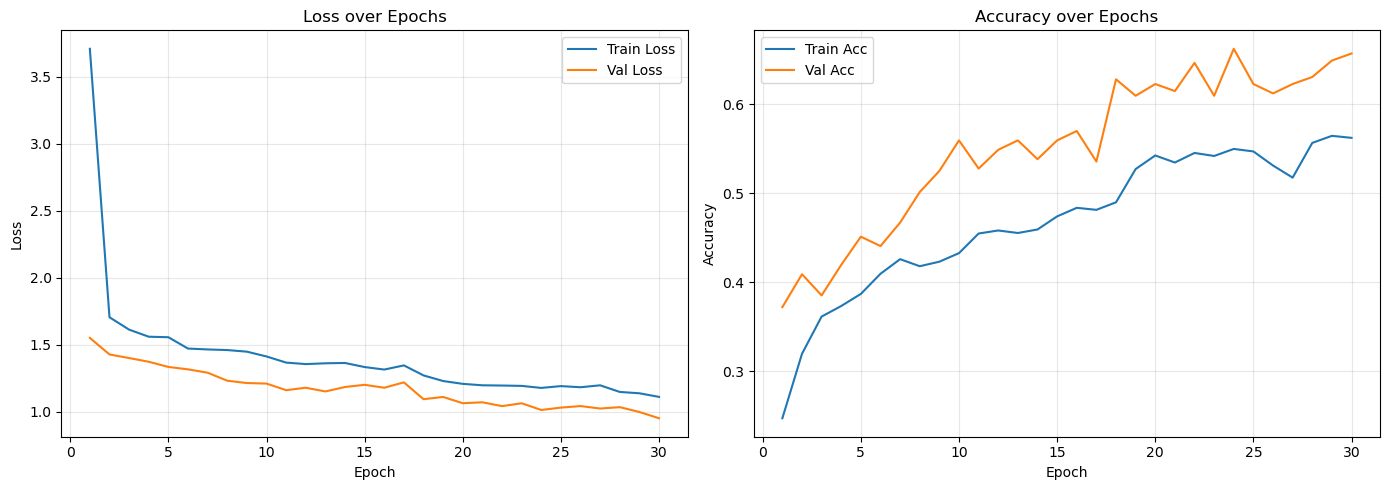

In [18]:
# plotting training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# loss
axes[0].plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
axes[0].plot(range(1, NUM_EPOCHS+1), val_losses, label='Val Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# accuracy
axes[1].plot(range(1, NUM_EPOCHS+1), train_accs, label='Train Acc')
axes[1].plot(range(1, NUM_EPOCHS+1), val_accs, label='Val Acc')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
# Part 3: Final Evaluation & Comparison
---

## 3.1 Evaluate CNN on Test Set

We load the best saved model and evaluate it on the held-out test set.

In [19]:
# load best model
best_model = WasteClassificationCNN(num_classes=6).to(device)
best_model.load_state_dict(torch.load('best_cnn_model.pth'))
best_model.eval()

# evaluating on test set
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc_cnn = test_correct / test_total
print(f"\nCNN Test Accuracy: {test_acc_cnn:.4f}")

# classification Report
print("\nClassification Report (CNN):")
print(classification_report(all_labels, all_preds, target_names=CLASSES))

/var/folders/m2/s530m3_j25s5l47hq37j0by40000gn/T/ipykernel_91698/2063196423.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_c


CNN Test Accuracy: 0.5895

Classification Report (CNN):
              precision    recall  f1-score   support

   cardboard       0.87      0.78      0.82        60
       glass       0.35      0.51      0.42        76
       metal       0.54      0.35      0.43        62
       paper       0.65      0.81      0.72        89
     plastic       0.69      0.60      0.64        73
       trash       0.00      0.00      0.00        20

    accuracy                           0.59       380
   macro avg       0.52      0.51      0.51       380
weighted avg       0.58      0.59      0.58       380




/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/cs171/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", resul

## 3.2 Confusion Matrix

Visualizing where the model makes mistakes.

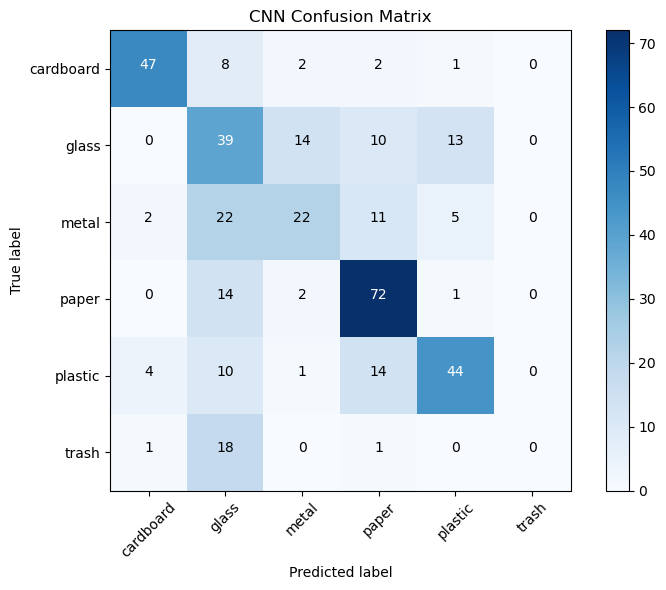

In [20]:
# plotting confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45)
plt.yticks(tick_marks, CLASSES)

# adding counts
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## 4. Conclusion

In this notebook, we built an end-to-end image classification pipeline for the **TrashNet-resized** dataset to answer our research question: **how well can a machine learning model classify common waste items into recycling/trash categories using only an image?** The dataset contained **2,527 images** across six classes (**cardboard: 403, glass: 501, metal: 410, paper: 594, plastic: 482, trash: 137**). We used a **stratified 70/15/15 split** to keep class proportions consistent (**train: 1,768; validation: 379; test: 380**) and highlighted that the dataset is **imbalanced**, especially for the *trash* class.

We evaluated two approaches:
1. **Classical ML baselines** using hand-crafted image features (as a sanity-check baseline).
2. A **CNN model** trained directly on images with normalization and data augmentation.

Overall, the **CNN achieved the strongest performance** on the validation/test sets (see results above), because it learns spatial and texture features that hand-crafted features and simpler classifiers often miss. The confusion matrix and classification report show that misclassifications tend to happen between **visually similar categories**, and the minority class (*trash*) is typically harder to predict reliably due to having far fewer training examples.

Despite these limitations, our results show that a well-structured deep learning pipeline can classify waste categories with useful accuracy and could be applied to support real-world sorting or educational tools. If we continued this project, the most impactful improvements would be: (1) handling imbalance (class weights or oversampling), (2) using transfer learning (e.g., ResNet/MobileNet), (3) evaluating macro-F1 in addition to accuracy, and (4) expanding training data to improve generalization across lighting/background conditions.

